In [1]:
%load_ext autoreload
%autoreload 2

## Load Data

In [2]:
from arbitragelab.cointegration_approach.multi_coint import MultivariateCointegration

import pandas as pd
import numpy as np

In [3]:
# Data is in my new multivariate cointegration branch.
euro_stocks_df = pd.read_csv("tests/test_data/multi_coint.csv", parse_dates=['Date'])
euro_stocks_df.set_index("Date", inplace=True)

In [4]:
euro_stocks_df

,AEX,DAX,FTSE,CAC
Date,,,,
1996-01-02,224.730007,2307.70,3687.90,1908.38
1996-01-03,226.622270,2326.18,3715.60,1942.96
1996-01-04,227.389158,2332.81,3714.10,1931.21
1996-01-05,225.787315,2315.66,3704.50,1917.72
1996-01-08,228.528146,2336.76,3720.60,1916.56
...,...,...,...,...
2006-12-21,494.620000,6573.96,6183.70,5510.39
2006-12-22,490.770000,6503.13,6189.97,5453.94
2006-12-27,497.780000,6608.86,6245.24,5540.01


## Train-Test Split

In [5]:
# This time point is selected according to the paper.
split_point = pd.Timestamp(2001, 11, 6)

# There are 1509 data points up to Nov 6th, 2001.
train_df = euro_stocks_df.iloc[:1509]
trade_df = euro_stocks_df.iloc[1509:]

1509


In [6]:
train_df

,AEX,DAX,FTSE,CAC
Date,,,,
1996-01-02,224.730007,2307.70,3687.90,1908.38
1996-01-03,226.622270,2326.18,3715.60,1942.96
1996-01-04,227.389158,2332.81,3714.10,1931.21
1996-01-05,225.787315,2315.66,3704.50,1917.72
1996-01-08,228.528146,2336.76,3720.60,1916.56
...,...,...,...,...
2001-10-30,452.630000,4543.98,5003.60,4251.93
2001-10-31,460.330000,4559.13,5039.71,4341.29
2001-11-01,464.990000,4636.13,5071.23,4366.94


In [7]:
trade_df

,AEX,DAX,FTSE,CAC
Date,,,,
2001-11-06,482.17,4707.65,5214.06,4461.69
2001-11-07,490.19,4860.66,5216.27,4493.27
2001-11-08,500.14,4993.57,5278.09,4573.04
2001-11-09,488.86,4910.07,5244.21,4514.28
2001-11-12,476.29,4820.37,5146.23,4376.58
...,...,...,...,...
2006-12-21,494.62,6573.96,6183.70,5510.39
2006-12-22,490.77,6503.13,6189.97,5453.94
2006-12-27,497.78,6608.86,6245.24,5540.01


## Generate Trading Signal and Checking Results

In [31]:
# Initialize the trading signal generator
multi_coint_signal = MultivariateCointegration(train_df, trade_df)

In [38]:
# Generating the signal, recording the cointegration vector time evolution and calculate portfolio returns.
signal, coint_vec, port_returns = multi_coint_signal.trading_signal(nlags=30, rolling_window_size=1500)

Here, the returns is calculated as follows.

The default portfolio notional for both longs and shorts are $\$$10M.

So on each day T, we generate the trading signal based on the price history up to day T-1. Open the positions at day T close and close the positions at day T+1 close. Calculate the PnL and derive the returns for the entire long/short portfolio, which has a notional value of $\$$20M, i.e.

\begin{equation}
\text{Daily Returns} = \frac{\text{PnL}}{\text{Total Notional}} = \frac{\text{PnL}}{\$20M}
\end{equation}

From here we can then compound the returns and derive the final return.

In [42]:
# Calculate the final return by compounding (cumprod).
final_return = (1 + port_returns).cumprod() - 1
final_return_value = final_return.iloc[-1].values[0]
final_return_value

0.24943637923051387

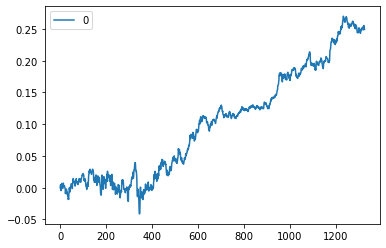

In [43]:
final_return.plot()

Some properties of the returns.

In [40]:
port_returns.describe()

,0
count,1327.000000
mean,0.000174
std,0.003398
min,-0.019840
25%,-0.001473
50%,0.000095
75%,0.001798
max,0.022511


In [41]:
print("Returns skew: {}".format(port_returns.skew().values[0]))

Returns skew: 0.12476952802765075


In [44]:
print("Returns kurt: {}".format(port_returns.kurt().values[0]))

Returns kurt: 5.525952291421662


In [46]:
print("Sharpe ratio: {}".format((port_returns.mean() / port_returns.std() * np.sqrt(252)).values[0]))

Sharpe ratio: 0.8110189524779347


In [48]:
down_returns = port_returns[port_returns[0] < 0]
print("Sortino ratio: {}".format((port_returns.mean() / down_returns.std() * np.sqrt(252)).values[0]))

Sortino ratio: 1.1224877175965775


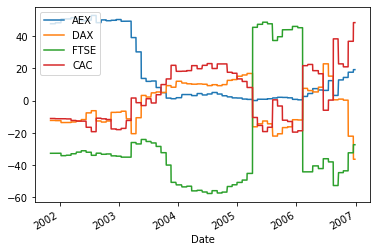

In [17]:
coint_vec.plot()